# Continuous Control with DDPG
---

This notebook is a walkthrough of the second assignment of the [Udacity Deep Reinforcement Learning Nanodegre](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893), which consists on solving the [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment using a Deep Reinforcement Learning algorithm. 

![alt text](https://video.udacity-data.com/topher/2018/June/5b1ea778_reacher/reacher.gif)

This environment a double-jointed can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in goal location. Thus, the goal of the agent is to mantain its position at the target location for as many steps as possible.

The observation consists of 33 variables (low-feature vector observation) corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with 4 numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

## Distributed Training
---

For this project it was provided two different Unity environments:

- The first one contains a single agent
- The second one (the one saw in the gif above) contains 20 identical agents, each with its own copy of the environment

On this work we'll explore the second version, using the [DDPG](https://arxiv.org/abs/1509.02971) algorithm to gather the experience of all the 20 agents updating the parameters of an actor-critic architecture. 

## Solve
---

The environment is considered solved when the average - over 100 episodes - of the average agent scores (considering all 20 agents) is at least +30. 

## DDPG
---

DDPG is an algorithm based on [Deep Q-Networks](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) to work on continous problems. It works with two networks: an actor and a critic. The actor is responsible for, given a state, perform an action (deterministic algorithm, choosing a single action, and not probabilities over the possible actions as DQN), while the critic will predict a score for this action on the state (judging how good was the action performed by the actor). 

Like DQNs, DDPG also works with Experience Replay, where it stores a bunch of `(state, action, rewards, next_state, done)` tuples and then sample it randomly for training (removing the correlation between state-action tuples). 

Also like DQNs, the DDPG has a `target` network for the actor and the critic, responsible for predicting the targets on the training stage. The weights of the local networks (the ones being trained) are used to *soft update* the weights of the `target` network, it means, after each iteration, a the weights of the networks are "*mixed*" together based on a parameter τ (which is much less than 1, we have used 0.001). The resulting weights of the `target` network are composed of τ times the weights of the `local` plus (1 - τ) times the current weights of the `target`. This technique has been proved to help stability during learning, ahd improves the result of the algorithm (it could also be used on the DQN arquitecture).

Deep reinforcement learning algorithms are successful because of a duality of exploration and exploitation. On the beginning of the training, the agent does not know much about the environment, and to help it explore the environment correctly, it is usual to add some randomness to the action-choosing process. On the DQN paper, this was implementeed based on a ε-greedy technique, where the agent could choose both the best known action or a random one (on the beginning of the training, the agent would usually choose random actions, and as training develops, the agent gets more *trustyworthy* and starts to choose the best known action). Since the DDPG does not work with probabilities over actions, it cannot make use of ε-greedy for exploration, and to address this problem it's often used to add some noise on the actions on the beginning of training (on the DDPG paper they've used Orsntein-Uhlenbeck noise process, on this work I've used the normal distribution). The noise added to the action keeps getting smaller as the number of episodes get bigger, and later on training the agent is always choosing the predicted action (without any noise). 

The DDPG algorithm used here has some differences than the original implementation, mainly because of the *multiple agent* environment. To make use of the distributed training, the algorithm records the experiences from all the agents (adding them to the Replay Buffer), and then every **20 timesteps** the agents are updated we use this experiences to **train the agents for 10 times**. To stabilize training, I've also clipped the *Critic's Network* gradients, to avoid rapidly changes and to help convergence. To address the issue of exploration, I've used the *Normal Distribution* as a noise function, that will be multiplied by a ε parameter, that will be smaller over time, making the actor chooses less randomness over the course of training. 



In [1]:
!pip -q install ../python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
from collections import deque

import torch
import numpy as np
import pandas as pd

from models.actor import Actor
from models.critic import Critic
from agent import Agent
from utils.utils import plot_result

from unityagents import UnityEnvironment
import matplotlib.pyplot as plt

from workspace_utils import active_session

%matplotlib inline

## Loading the Environment

On this project it was used an environment with 20 agents.

In [3]:
# path = 'env/multiple/Reacher.app'
path = '/data/Reacher_Linux_NoVis/Reacher.x86_64'

In [4]:
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {states.shape[0]} agents. Each observes a state with length: {state_size}')
print(f'The state for the first agent looks like: {states[0]}')

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## Agent

The `Agent` class was developed to iterate with the environment, collected the `(state, action, next_state, rewards, done)` tuples and stack them up to a Replay Buffer, to use the `actor` network to choose an action to perform in the environment and to learn from those actions (10 times every 20 timesteps, as mentioned above).

The constructor of this class receives the `state_size` and `action_size` as the environments parameters, and the size of the layers of both of the networks, `Actor` and `Critic`, which has been chosen 400 neurons on the first layer and 300 on the second. 

The starting ε is going to be 1.0, with a *decay rate* of 0.99 and a minimum of 0.01 (it means, it will decay 0.99 every episode, until it reaches a minimum of 0.01). This network is going to be trained for as much as 1000 episodes (but it's scheduled to stop as soon as it solves the environment - i.e. achieves a mean score of +30 over 100 episodes).

In [7]:
agent = Agent(state_size, action_size, 25, [400, 300], [400, 300])
n_episodes = 1000
max_t = 3000
print_every = 100

eps_start=1.0
epsilon_decay = 0.99
eps_end = 0.01

Agent running on cuda:0


In [8]:
action = agent.act(states)
env_info = env.step(action)[brain_name]

## Training

The training process is fairly similar to the DQN. States are sampled from the environment, and then an action is requested to the `Agent`, this action is performed on the environment, which returns a `(state, action, next_state, reward, done)` tuple, that is used on the `step` function of the `Agent`, where it stores this tuple on the Replay Buffer and, if this step is multiple of 20 (remember that the network is only trained every 20 timesteps) we'll use those values to backpropagate over the `Actor` and `Critic` networks and train them over 10 times.

In [10]:
scores_deque = deque(maxlen=100)
scores = []

eps = eps_start
with active_session():
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)

        for t in range(1, max_t+1):
            actions = agent.act(state, epsilon=eps)
            env_info = env.step(actions)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, actions, reward, next_state, done, t)
            state = next_state
            score += env_info.rewards
            if np.any(done):
                break

        eps = max(eps_end, eps*epsilon_decay)
        scores_deque.append(score)
        scores.append(score)
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.4f}", end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        if i_episode % print_every == 0 or np.mean(scores_deque) >= 30:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.4f}")
            if np.mean(scores_deque) >= 30:
                print(f'Environment solved on episode {i_episode}')
                break

Episode 100	Average Score: 12.5014
Episode 170	Average Score: 30.0336
Environment solved on episode 170


The results show that the network has solved the environment on episode 170, where it has achieved a mean score (over 100 episodes and all of the 20 agents) of +30.0336. 

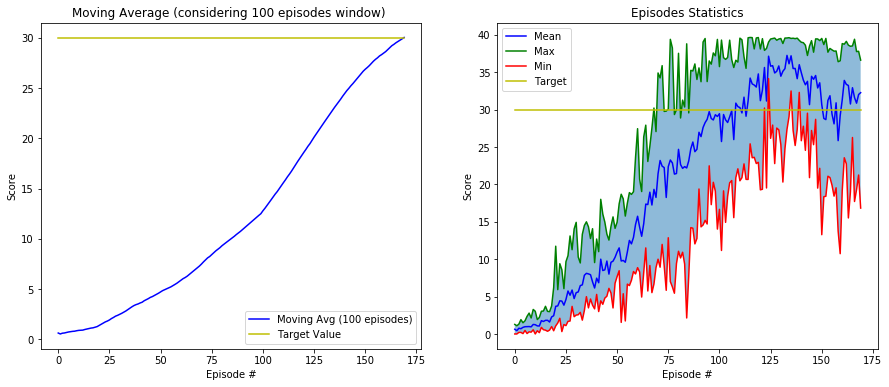

In [16]:
plot_result(scores)

In [11]:
env.close()

## Future Work

There are some modifications that could be made on this network, such as the use of *Orsntein-Uhlenbeck* noise in the exploration process (instead of the *Normal Distribution*), but even though it is already implemented, I couldn't tweak the parameters to make it work during training. Another modification could be a Prioritized Experience Replay, that has seemed to make the training faster, since its prioritizing the experiences that the agent learns, making the most useful ones be used more often. 

A future work that it's on my plan is to train a network on Continuous Control and using the raw pixels, instead of the low-dimensional feature vector. Probably by the beginning of next year I will work on it!